# Facial keypoints

In [2]:
import numpy as np

import torch, torch.utils.data
import torchvision
from torchvision.models.resnet import BasicBlock

import matplotlib.pyplot as plt

import lib.pytorch_trainer as ptt

## Train file

In [4]:
npzfile = np.load('/data/datasets/facial_features/train.npz')
x, y = npzfile['x'], npzfile['y']
print(x.dtype, x.shape, x.min(), x.max())
print(y.dtype, y.shape, y.min(), y.max())

uint8 (7000, 1, 96, 96) 0 255
float32 (7000, 8) 0.686592 95.809


## Test file

In [5]:
npzfile = np.load('/data/datasets/facial_features/test.npz')
x = npzfile['x']
print(x.dtype, x.shape, x.min(), x.max())

uint8 (1783, 1, 96, 96) 0 255


## Dataset

In [6]:
class DatasetFacialKeypoints(torch.utils.data.Dataset):
    def __init__(self, filepath, train=True, split=.8, transform=None):
        super().__init__()
        self.transform = transform
        npzfile = np.load(filepath)
        x = npzfile['x']
        try:
            y = npzfile['y']
        except KeyError:
            y = None
        if y is not None:
            n_train = int(np.round(x.shape[0] * split))
            if train:
                self.x = x[:n_train]
                self.y = y[:n_train]
            else:
                self.x = x[n_train:]
                self.y = y[n_train:]
        else:
            self.x = x
            self.y = y
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, idx):
        if self.transform is not None:
            xi = self.transform(self.x[idx].repeat(3, axis=0).transpose(1, 2, 0))
        else:
            xi = self.x[idx]
        if self.y is None:
            yi = None
        else:
            yi = torch.FloatTensor(self.y[idx])
        return xi, yi

In [8]:
ds_train = DatasetFacialKeypoints('/data/datasets/facial_features/train.npz', train=True, transform=torchvision.transforms.ToTensor())
ds_valid = DatasetFacialKeypoints('/data/datasets/facial_features/train.npz', train=False, transform=torchvision.transforms.ToTensor())
ds_test = DatasetFacialKeypoints('/data/datasets/facial_features/test.npz', transform=torchvision.transforms.ToTensor())
for ds in [ds_train, ds_valid, ds_test]:
    x, y = next(iter(ds))
    print(len(ds))
    print(type(x), x.shape, x.min(), x.max())
    if y is not None:
        print(type(y), y.shape, y.min(), y.max())
    else:
        print(type(y))
    print()

5600
<class 'torch.FloatTensor'> torch.Size([3, 96, 96]) 0.007843137718737125 0.9921568632125854
<class 'torch.FloatTensor'> torch.Size([8]) 30.227006912231445 84.48577117919922

1400
<class 'torch.FloatTensor'> torch.Size([3, 96, 96]) 0.0 1.0
<class 'torch.FloatTensor'> torch.Size([8]) 27.133085250854492 79.06320190429688

1783
<class 'torch.FloatTensor'> torch.Size([3, 96, 96]) 0.0 0.7490196228027344
<class 'NoneType'>



In [9]:
loader_train = torch.utils.data.DataLoader(ds_train, batch_size=len(ds_train), shuffle=True)
loader_valid = torch.utils.data.DataLoader(ds_valid, batch_size=len(ds_valid), shuffle=False)
loader_test = torch.utils.data.DataLoader(ds_test, batch_size=len(ds_test), shuffle=False)
x_train, y_train = next(iter(loader_train))
print(x_train.size(), y_train.size())
x_valid, y_valid = next(iter(loader_valid))
print(x_valid.size(), y_valid.size())

torch.Size([5600, 3, 96, 96]) torch.Size([5600, 8])
torch.Size([1400, 3, 96, 96]) torch.Size([1400, 8])


## Model (modified resnet18, convolutional layer1 transfer learning)

In [12]:
class MyResNetConv(torchvision.models.ResNet):
    def __init__(self):
        super().__init__(BasicBlock, [2, 2, 2, 2])
        self.load_state_dict(torch.utils.model_zoo.load_url(
            'https://download.pytorch.org/models/resnet18-5c106cde.pth'))
        del self.layer2
        del self.layer3
        del self.layer4
        del self.fc
        for param in self.parameters():
            param.requires_grad = False
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

class MyResNetDens(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.dens1 = torch.nn.Linear(in_features=64*3*3, out_features=100)
        self.dens2 = torch.nn.Linear(in_features=100, out_features=8)
    def forward(self, x):
        x = self.dens1(x)
        x = torch.nn.functional.selu(x)
        x = self.dens2(x)
        return x

class MyResNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mrnc = MyResNetConv()
        self.mrnd = MyResNetDens()
    def forward(self, x):
        x = self.mrnc(x)
        x = self.mrnd(x)
        return x

model = MyResNet()
if torch.cuda.is_available():
    model = model.cuda()
#     x_train = x_train.cuda()
#     y_train = y_train.cuda()
print(model)

# o0 = model(torch.autograd.Variable(x_train))
# print(o0.data.size())

# o1 = model.mrnc(torch.autograd.Variable(x_train))
# print(o1.data.size())

# o2 = model.mrnd(o1)
# print(o2.data.size())

MyResNet (
  (mrnc): MyResNetConv (
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU (inplace)
    (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (layer1): Sequential (
      (0): BasicBlock (
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU (inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): BasicBlock (
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU (inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride

## Features

In [13]:
inp_train = x_train
inp_valid = x_valid
if torch.cuda.is_available():
    inp_train = inp_train.cuda()
    inp_valid = inp_valid.cuda()
inp_train = torch.autograd.Variable(inp_train)
inp_valid = torch.autograd.Variable(inp_valid)

feat_train = model.mrnc(inp_train).data
feat_valid = model.mrnc(inp_valid).data

print(feat_train.size())
print(feat_valid.size())

torch.Size([5600, 576])
torch.Size([1400, 576])


## Training (using features from transfer learning)

In [15]:
n_epochs = 500
criterion = torch.nn.MSELoss()
optm = torch.optim.RMSprop(params=model.mrnd.parameters(), lr=1e-4)
fp_model = '../../models/facialfeatures'
cb_chkpt = ptt.ModelCheckpoint(fp_model, reset=True, verbose=1)

trainer = ptt.DeepNetTrainer(model         = model.mrnd,
                             criterion     = criterion,
                             optimizer     = optm,
                             callbacks = [ptt.PrintCallback(),
                                          cb_chkpt
                                         ])

In [16]:
train = True
if train:
    trainer.fit(n_epochs   = n_epochs,
                Xin        = feat_train,
                Yin        = y_train,
                shuffle    = True,
                batch_size = 100,
                valid_data = (feat_valid, y_valid))
else:
    trainer.load_state(fp_model)

Start training for 500 epochs
  1:   0.3s   T: 2309.11968   V: 1936.23841 best
  2:   0.2s   T: 1555.69163   V: 1293.92759 best
  3:   0.2s   T: 1000.69258   V: 809.86560 best
  4:   0.2s   T: 596.77849   V: 469.28188 best
  5:   0.2s   T: 326.80400   V: 251.07262 best
  6:   0.2s   T: 164.70518   V: 126.51277 best
  7:   0.2s   T: 79.54532   V: 64.31567 best
  8:   0.2s   T: 41.33270   V: 37.43464 best
  9:   0.2s   T: 27.32247   V: 27.48222 best
 10:   0.2s   T: 23.23860   V: 24.16252 best
 11:   0.2s   T: 22.22080   V: 22.79331 best
 12:   0.2s   T: 21.93753   V: 22.25032 best
 13:   0.2s   T: 21.74408   V: 21.90609 best
 14:   0.2s   T: 21.52861   V: 21.87445 best
 15:   0.2s   T: 21.28381   V: 21.46824 best
 16:   0.3s   T: 20.98220   V: 21.04184 best
 17:   0.3s   T: 20.64427   V: 21.00245 best
 18:   0.3s   T: 20.27756   V: 20.49346 best
 19:   0.2s   T: 19.86520   V: 19.95108 best
 20:   0.3s   T: 19.49195   V: 19.84526 best
 21:   0.3s   T: 19.08188   V: 19.31590 best
 22:   0

196:   0.2s   T: 6.66177   V: 10.25729 
197:   0.2s   T: 6.62309   V: 9.79504 
198:   0.2s   T: 6.60473   V: 9.87092 
199:   0.2s   T: 6.60136   V: 9.75703 
200:   0.2s   T: 6.61651   V: 9.40083 best
201:   0.2s   T: 6.58426   V: 9.69416 
202:   0.2s   T: 6.58019   V: 9.45669 
203:   0.2s   T: 6.56136   V: 9.68570 
204:   0.2s   T: 6.54796   V: 9.82972 
205:   0.2s   T: 6.54904   V: 9.51075 
206:   0.2s   T: 6.53363   V: 9.59425 
207:   0.2s   T: 6.53282   V: 9.89203 
208:   0.2s   T: 6.51315   V: 9.31898 best
209:   0.2s   T: 6.49207   V: 9.51292 
210:   0.2s   T: 6.47988   V: 9.32329 
211:   0.2s   T: 6.49296   V: 10.00715 
212:   0.2s   T: 6.47554   V: 9.64025 
213:   0.2s   T: 6.45180   V: 9.70507 
214:   0.2s   T: 6.45889   V: 9.99208 
215:   0.2s   T: 6.43831   V: 9.49235 
216:   0.2s   T: 6.43631   V: 9.45892 
217:   0.2s   T: 6.43585   V: 9.32822 
218:   0.2s   T: 6.41630   V: 9.42417 
219:   0.2s   T: 6.39705   V: 9.81425 
220:   0.2s   T: 6.41288   V: 9.35048 
221:   0.2s   T

405:   0.2s   T: 5.34967   V: 8.51386 
406:   0.2s   T: 5.35310   V: 8.23090 best
407:   0.2s   T: 5.37783   V: 8.57587 
408:   0.2s   T: 5.33368   V: 9.59619 
409:   0.3s   T: 5.35490   V: 8.79342 
410:   0.2s   T: 5.34480   V: 8.87284 
411:   0.2s   T: 5.34583   V: 8.54759 
412:   0.2s   T: 5.32949   V: 8.49159 
413:   0.2s   T: 5.36265   V: 8.80809 
414:   0.2s   T: 5.30525   V: 8.37278 
415:   0.2s   T: 5.32414   V: 8.50057 
416:   0.2s   T: 5.32185   V: 8.24235 
417:   0.2s   T: 5.30399   V: 9.01495 
418:   0.2s   T: 5.32284   V: 8.30871 
419:   0.2s   T: 5.30462   V: 8.78047 
420:   0.3s   T: 5.30254   V: 8.58019 
421:   0.3s   T: 5.29320   V: 8.78319 
422:   0.2s   T: 5.31302   V: 8.91249 
423:   0.2s   T: 5.27839   V: 8.63686 
424:   0.2s   T: 5.29147   V: 9.14379 
425:   0.2s   T: 5.28478   V: 8.68025 
426:   0.2s   T: 5.28506   V: 8.38731 
427:   0.2s   T: 5.27988   V: 8.90243 
428:   0.3s   T: 5.27976   V: 9.01422 
429:   0.3s   T: 5.28447   V: 8.47574 
430:   0.2s   T: 5.25

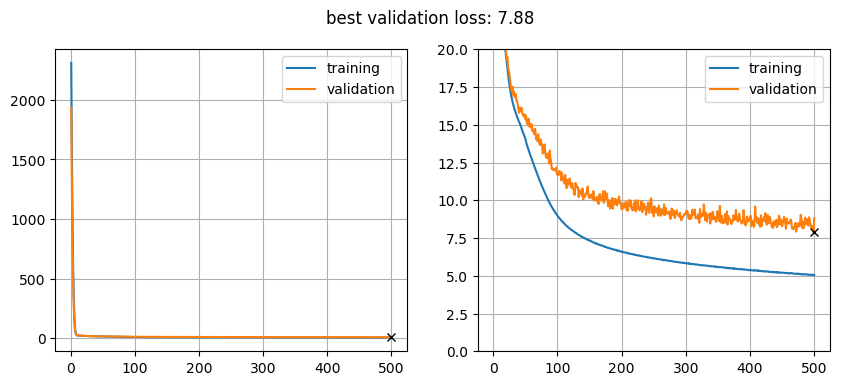

In [17]:
idx = np.argmin(trainer.metrics['valid']['losses'])
a_epochs = np.arange(1, 1 + len(trainer.metrics['valid']['losses']))
fig = plt.figure(figsize=(10, 4), dpi=100)
fig.suptitle('best validation loss: {:.2f}'.format(trainer.metrics['valid']['losses'][idx]))
ax = fig.add_subplot(1, 2, 1)
ax.plot(a_epochs, trainer.metrics['train']['losses'], label='training')
ax.plot(a_epochs, trainer.metrics['valid']['losses'], label='validation')
ax.plot(idx + 1, trainer.metrics['valid']['losses'][idx], 'kx')
# ax.set_yscale('log')
ax.legend()
ax.grid(True)
ax = fig.add_subplot(1, 2, 2)
ax.plot(a_epochs, trainer.metrics['train']['losses'], label='training')
ax.plot(a_epochs, trainer.metrics['valid']['losses'], label='validation')
ax.plot(idx + 1, trainer.metrics['valid']['losses'][idx], 'kx')
ax.set_ylim(0., 20.)
ax.legend()
ax.grid(True)
plt.show()

## Results

In [18]:
loader_valid = torch.utils.data.DataLoader(ds_valid, batch_size=1, shuffle=False)
l_loss = list()
l_output = list()
model.eval()
for x_valid, y_valid in loader_valid:
    if torch.cuda.is_available():
        inp = torch.autograd.Variable(x_valid.cuda())
        tgt = torch.autograd.Variable(y_valid.cuda())
    else:
        inp = torch.autograd.Variable(x_valid)
        tgt = torch.autograd.Variable(y_valid)
    out = model(inp)
    l_loss.append(criterion(out, tgt).cpu().data.numpy()[0])
    l_output.append(out.cpu().data.numpy().tolist())
a_loss = np.array(l_loss, dtype=np.float)
a_output = np.array(l_output, dtype=np.float)

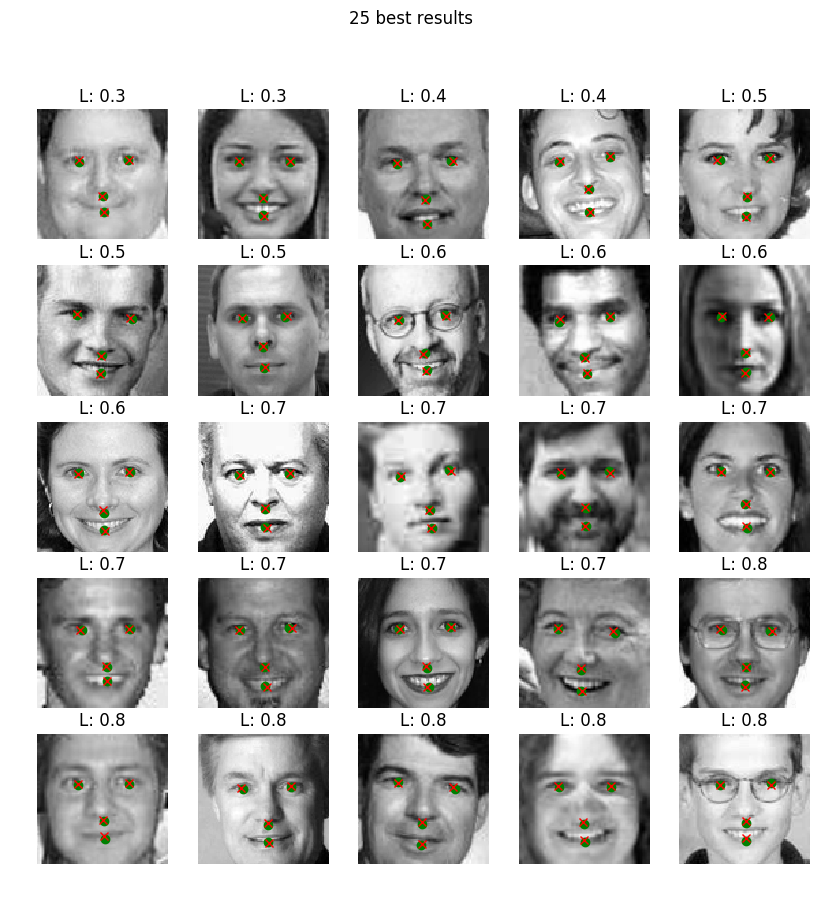

In [19]:
h, w = 5, 5
idxs_order = np.argsort(a_loss)
fig = plt.figure(figsize=(2 * w, 2 * h), dpi=100)
fig.suptitle('{} best results'.format(h * w))
for i_img, i_order in enumerate(idxs_order[:h * w]):
    ax = fig.add_subplot(h, w, 1 + i_img)
    ax.set_title('L: {:.1f}'.format(l_loss[i_order]))
    x, y = ds_valid[i_order]
    a_y = y.cpu().numpy().reshape(-1, 2)
    a_o = a_output[i_order].reshape(-1, 2)
    ax.imshow(x[0].cpu().numpy(), cmap='gray')
    ax.plot(a_y[:, 0], a_y[:, 1], 'go')
    ax.plot(a_o[:, 0], a_o[:, 1], 'rx')
    ax.axis('off')
plt.show()

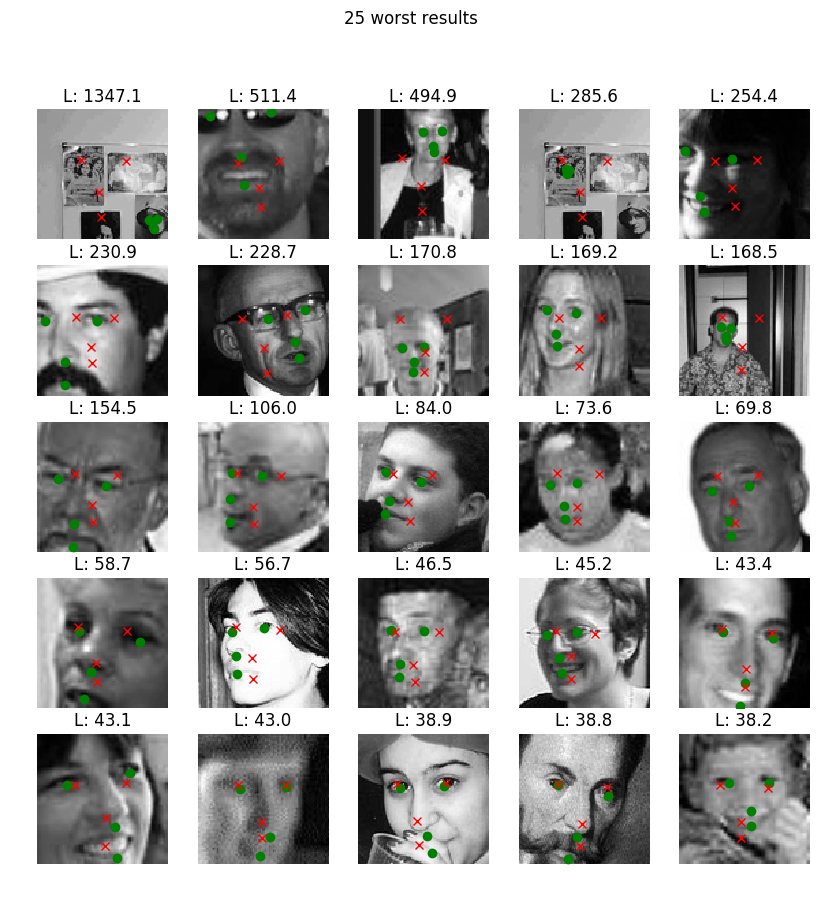

In [20]:
h, w = 5, 5
idxs_order = np.argsort(a_loss)
fig = plt.figure(figsize=(2 * w, 2 * h), dpi=100)
fig.suptitle('{} worst results'.format(h * w))
for i_img, i_order in enumerate(idxs_order[:-h * w - 1: -1]):
    ax = fig.add_subplot(h, w, 1 + i_img)
    ax.set_title('L: {:.1f}'.format(l_loss[i_order]))
    x, y = ds_valid[i_order]
    a_y = y.cpu().numpy().reshape(-1, 2)
    a_o = a_output[i_order].reshape(-1, 2)
    ax.imshow(x[0].cpu().numpy(), cmap='gray')
    ax.plot(a_y[:, 0], a_y[:, 1], 'go')
    ax.plot(a_o[:, 0], a_o[:, 1], 'rx')
    ax.axis('off')
plt.show()

## Exercícios

1. Analise os dados anotados: o que é a entrada e o que é a saída.
2. Este é um problema de regressão ou de classificação?
3. Qual é a medida de desempenho?